In [1]:
import bolift
import pandas as pd
import numpy as np
import cloudpickle

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (5.0, 5.0 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

# RF baseline

## Experiment outputs

In [ ]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = df.keys()[:index]
labels = df.keys()[index+1:-6]
features, labels


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )

    X_train, y_train = train
    X_test, y_test = test
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

models = {}
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(train_df.keys())

for i, k in enumerate(labels):
    # print(k, i, labels[i])
    train = (train_df[features], train_df[labels[i]])
    test = (test_df[features], test_df[labels[i]])
    models[k] = train_model(train, test)

    

In [ ]:
k = 0
sample = test_df.iloc[k:k+1]
feats = sample[features]
labs = sample[labels]

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

for k in labels:
    # print(k, rmse(models[k].predict(feats), labs[k].values))
    print(k, models[k].predict(feats), labs[k].values)

w = [float(a) for a in sample.iloc[0]['Fl_Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample.iloc[0]['Fluorescence_norm'][1:-1].split(',')]

# plt.figure(figsize=(6, 4))
plt.plot(w, i, color="C0", label="Reference")
# plt.title(f"{sample.iloc[0]['Experiment']}: {sample.iloc[0]['Temperature(C)']}°C, {sample.iloc[0]['Doping(%)']}%, {sample.iloc[0]['Time(min)']}min")
plt.title(f"XGBoost Model Prediction: Spectra Metrics")
plt.axvline(x = models['Peak1'].predict(sample[features]), color = 'C1', linestyle = '--', label = 'Peak1')
plt.axvline(x = models['Peak2'].predict(sample[features]), color = 'C3', linestyle = '--', label = 'Peak2')
# change plt figsize
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized fluorescence (a.u.)")
plt.tight_layout()
plt.legend()
plt.show()

## Spectra output

In [ ]:
df = pd.read_csv('Data/fl_spectra_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']).count()

In [ ]:
index = df.keys().tolist().index('Experiment')
features = list(df.keys()[:index]) + ['Wavelength(nm)']
labels = ['Fluorescence_norm']
features, labels

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def train_model(train, test):
    model = XGBRegressor(
    eval_metric=mean_absolute_error 
    )
    
    X_train, y_train = train[train.columns.difference(['Fluorescence', 'Fluorescence_norm'])], train['Fluorescence_norm']
    X_test, y_test = test[test.columns.difference(['Fluorescence', 'Fluorescence_norm'])], test['Fluorescence_norm']
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)
    
    return model

def test_model(model, validation):
    val_feats = validation[validation.columns.difference(['Fluorescence', 'Fluorescence_norm'])]
    val_labels = validation["Fluorescence_norm"]

    pred = model.predict(val_feats)
    return (pred, val_labels.to_numpy(), val_feats['Wavelength(nm)'].to_numpy())

In [23]:
from sklearn.model_selection import train_test_split

one_out = []
i=0
for group, validation in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    data = df.copy()
    exp, T, d, t = group
    validation = validation[features + labels]

    # validation = data.query(
    #     f'`Temperature(C)` == {T} & `Doping(%)` == {d} & `Time` == {t}'
    # )
    train_df = data.drop(validation.index)
    train, test = train_test_split(train_df[features + labels], test_size=0.2, random_state=42)

    model = train_model(train, test)

    prediction = test_model(model, validation)
    one_out.append((group, prediction))


KeyError: 'Experiment'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
i=0
for group, predictions in one_out:
    axs = axs.flatten()
    exp, T, d, t = group
    if exp not in ["8_NPL-13_(3-8-23)", "7_NPL-12_(3-8-23)"] or T != 0.0 or t != 60:
        continue
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    title = f"Doping: {d}%"

    if i == 0:
        axs[i].plot(predictions[2], predictions[0], color="C0", label='Prediction')
        axs[i].plot(predictions[2], predictions[1], color="C1", label='labels')
    else:
        axs[i].plot(predictions[2], predictions[0], color="C0")
        axs[i].plot(predictions[2], predictions[1], color="C1")
    axs[i].set_title(title)

    i+=1 
    # plt.savefig(f'preds/{group}.png')
fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
fig.suptitle(f"7_NPL-12_(3-8-23) and 8_NPL-13_(3-8-23): T: 25 ºC, Time: 60 min")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

i=0
for group, predictions in one_out:
    if i == 0:
        exp, T, d, t = group
        title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
        plt.figure()
        sns.lineplot(x=predictions[2], y=predictions[1], label='Reference')
        sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction')
        plt.legend()
        # plt.savefig(f'preds/{group}.png')
        fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
        # plt.title(title)
        plt.title("XGBoost Model Prediction: Entire Spectra")
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Normalized fluorescence (a.u.)")
        plt.tight_layout()
        plt.show()
    i += 1



### Evaluate predictions

In [13]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [ ]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

pred_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}
label_dict = {
    "Peak1": [],
    "Peak2": [],
    "Area1": [],
    "Area2": [],
    "Distance_peaks": []
}

for group, predictions in one_out:
    pred_peak = get_peaks(predictions[2], predictions[0])
    pred_norm_area = get_area_under_peaks(predictions[2], predictions[0])
    pred_area = get_area_under_peaks(predictions[2], predictions[0], norm=pred_norm_area)

    label_peak = get_peaks(predictions[2], predictions[1])
    label_norm_area = get_area_under_peaks(predictions[2], predictions[1])
    label_area = get_area_under_peaks(predictions[2], predictions[1], norm=label_norm_area)
    
    pred_dict["Peak1"].append(pred_peak[0])
    pred_dict["Peak2"].append(pred_peak[1])
    pred_dict["Area1"].append(pred_area[0])
    pred_dict["Area2"].append(pred_area[1])
    pred_dict["Distance_peaks"].append(pred_peak[1] - pred_peak[0])

    label_dict["Peak1"].append(label_peak[0])
    label_dict["Peak2"].append(label_peak[1])
    label_dict["Area1"].append(label_area[0])
    label_dict["Area2"].append(label_area[1])
    label_dict["Distance_peaks"].append(label_peak[1] - label_peak[0])
    
    #plot
    # exp, T, d, t = group
    # title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
    # plt.figure()
    # sns.lineplot(x=predictions[2], y=predictions[0], label='Prediction').set(title=title)
    # sns.lineplot(x=predictions[2], y=predictions[1], label='label')
    # plt.legend()
    # plt.show()    

for k in pred_dict.keys():
    print(k, rmse(np.array(pred_dict[k]), np.array(label_dict[k])))

# bolift

In [3]:
import os
import cloudpickle
import bolift
import seaborn as sns
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [4]:
df = pd.read_csv('Data/procedures.tsv', sep="\t")

import numpy as np
indexes = np.arange(len(df))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

with open('Data/system_message.txt', 'r') as f:
    system_message = f.read()

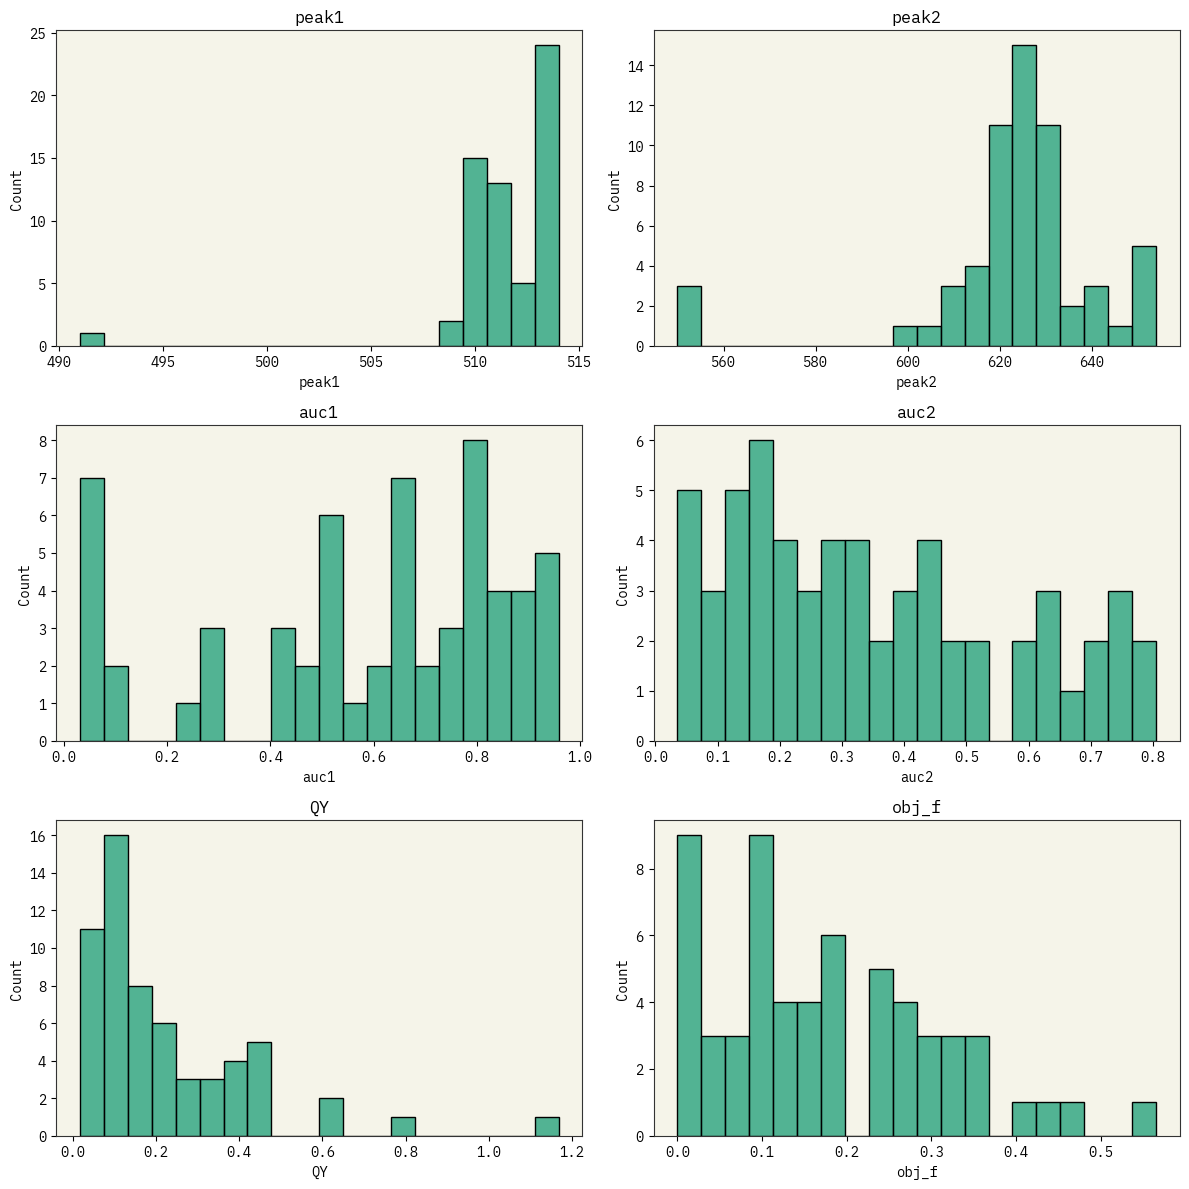

In [6]:
# plot historgram of peak1, peak2, auc1, auc2, qy, and obj_f

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()
for i, k in enumerate(['peak1', 'peak2', 'auc1', 'auc2', 'QY', 'obj_f']):
    sns.histplot(df[k], ax=axs[i], bins=20)
    axs[i].set_title(k)
plt.tight_layout()
plt.show()


## Predicting peaks

In [41]:
asktell_peak1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell_peak2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_peak1.tell(df['prompt'][i], df['peak1'][i])

for i in train_indexes:
    asktell_peak2.tell(df['prompt'][i], df['peak2'][i])

In [42]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
yhat_2=[]
y_1=[]
y_2=[]
for i in test_indexes:
  yhat_1.append(asktell_peak1.predict(df['prompt'][i], system_message=system_message))
  yhat_2.append(asktell_peak2.predict(df['prompt'][i], system_message=system_message))
  y_1.append(df['peak1'][i])
  y_2.append(df['peak2'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['peak1'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {df['peak2'][i]}")


511.00+/-1.59 : 510.0 // 643.00+/-1.79 : 623.0
511.00+/-1.59 : 511.0 // 643.00+/-1.79 : 633.0
511.00+/-1.59 : 511.0 // 643.00+/-1.79 : 632.0
511.00+/-1.59 : 514.0 // 643.00+/-1.79 : 550.0
511.00+/-1.59 : 513.0 // 643.00+/-1.79 : 632.0
511.00+/-1.59 : 513.0 // 643.00+/-1.79 : 624.0
511.00+/-1.59 : 511.0 // 643.00+/-1.79 : 610.0
511.00+/-1.59 : 511.0 // 643.00+/-1.79 : 550.0
511.00+/-1.59 : 510.0 // 643.00+/-1.79 : 624.0
511.00+/-1.59 : 514.0 // 643.00+/-1.79 : 619.0
511.00+/-1.59 : 512.0 // 643.00+/-1.79 : 641.0
511.00+/-1.59 : 510.0 // 643.00+/-1.79 : 604.0


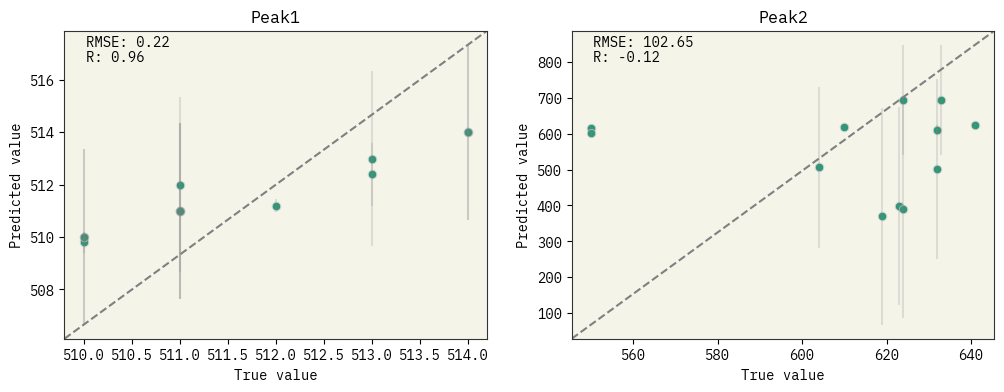

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("Peak1")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs[0])
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs[0].transAxes)

axs[1].set_title("Peak2")
sns.scatterplot(x=y_2, y=[yi.mean() for yi in yhat_2], ax=axs[1])
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(y_2), np.array([yi.mean() for yi in yhat_2])):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_2, [yi.mean() for yi in yhat_2])[0, 1]:.2f}", transform=axs[1].transAxes)



plt.show()

In [ ]:
i=0
for group, predictions in one_out:
    if i == 0:
        exp, T, d, t = group
        title = f"{exp}: T: {T}ºC, Doping: {d}%, Time: {t}min"
        plt.figure()
        sns.lineplot(x=predictions[2], y=predictions[1], label='Reference')
        plt.axvline(x = asktell1.predict(prompts[0]).mean(), color = 'C1', linestyle = '--', label = 'Peak1')
        plt.axvline(x = asktell2.predict(prompts[0]).mean(), color = 'C3', linestyle = '--', label = 'Peak2')
        fig.legend(loc='center', bbox_to_anchor=(0.5,0), fancybox=True, shadow=True, ncol=2)
        # plt.title(title)
        plt.title("LLM Prediction: Spectra Metrics")
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Normalized fluorescence (a.u.)")
        plt.tight_layout()
        plt.show()
    i += 1

## Predicting areas

In [50]:
asktell_auc1 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="area under the first peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

asktell_auc2 = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="area under the second peak in the fluorescence spectrum",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_auc1.tell(df['prompt'][i], df['auc1'][i])

for i in train_indexes:
    asktell_auc2.tell(df['prompt'][i], df['auc2'][i])

In [53]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
yhat_2=[]
y_1=[]
y_2=[]
for i in test_indexes:
  yhat_1.append(asktell_auc1.predict(df['prompt'][i], system_message=system_message))
  yhat_2.append(asktell_auc2.predict(df['prompt'][i], system_message=system_message))
  y_1.append(df['auc1'][i])
  y_2.append(df['auc2'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['auc1'][i]} // {yhat_2[-1].mean():.2f}+/-{yhat_2[-1].std():.2f} : {df['auc2'][i]}")


0.74+/-0.03 : 0.669233798373332 // 0.20+/-0.04 : 0.2953657940256268
0.56+/-0.15 : 0.6055993906428825 // 0.17+/-0.07 : 0.2828481825878629
0.76+/-0.06 : 0.537803447645178 // 0.21+/-0.01 : 0.3898966338880653
0.81+/-0.01 : 0.9293561075612538 // 0.13+/-0.02 : 0.0629136968193054
0.69+/-0.04 : 0.6642130197359394 // 0.27+/-0.04 : 0.2912090093164146
0.53+/-0.04 : 0.4519978530450739 // 0.46+/-0.15 : 0.4682733133999453
0.49+/-0.17 : 0.6531595127533121 // 0.54+/-0.05 : 0.3117200227028498
0.92+/-0.01 : 0.9303358223223664 // 0.05+/-0.00 : 0.0573401540691778
0.89+/-0.01 : 0.9010368098015976 // 0.10+/-0.01 : 0.0840665229012216
0.78+/-0.02 : 0.8062569113563689 // 0.14+/-0.01 : 0.1733997206063347
0.14+/-0.16 : 0.0482269515458408 // 0.51+/-0.17 : 0.8048366297467044
0.86+/-0.01 : 0.9046348559691936 // 0.12+/-0.00 : 0.0841559783264317


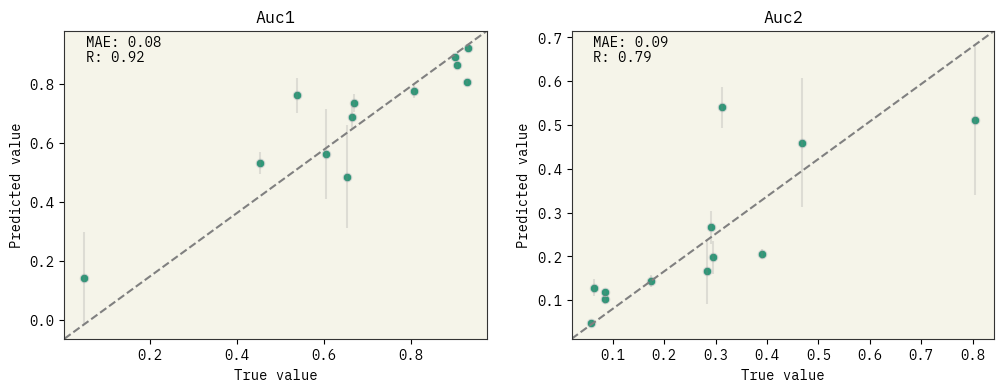

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs[0].set_title("Auc1")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs[0])
axs[0].set_xlabel("True value")
axs[0].set_ylabel("Predicted value")
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, ls="--", color="gray")
axs[0].errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs[0].text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs[0].transAxes)
axs[0].text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs[0].transAxes)

axs[1].set_title("Auc2")
sns.scatterplot(x=y_2, y=[yi.mean() for yi in yhat_2], ax=axs[1])
axs[1].set_xlabel("True value")
axs[1].set_ylabel("Predicted value")
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, ls="--", color="gray")
axs[1].errorbar(x=y_2, y=[yi.mean() for yi in yhat_2], yerr=[yi.std() for yi in yhat_2], fmt='o', color='gray', alpha=0.2)
axs[1].text(0.05, 0.95, f"MAE: {mae(np.array(y_2), np.array([yi.mean() for yi in yhat_2])):.2f}", transform=axs[1].transAxes)
axs[1].text(0.05, 0.90, f"R: {np.corrcoef(y_2, [yi.mean() for yi in yhat_2])[0, 1]:.2f}", transform=axs[1].transAxes)

plt.show()

## Predicting QY

In [55]:
asktell_qy = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="quantum yield",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

for i in train_indexes:
    asktell_qy.tell(df['prompt'][i], df['QY'][i])

In [61]:
# system_message = "You are a bot that can accurately predict chemical and material properties from their synthesis and experimental procedures. Do not explain answers, just provide numerical predictions."

yhat_1=[]
y_1=[]
for i in test_indexes:
  yhat_1.append(asktell_auc1.predict(df['prompt'][i], system_message=system_message))
  y_1.append(df['QY'][i])
  print(f"{yhat_1[-1].mean():.2f}+/-{yhat_1[-1].std():.2f} : {df['QY'][i]}")


0.68+/-0.10 : 0.3344876494548325
0.66+/-0.21 : 0.020962473350054
0.75+/-0.08 : 0.1011158776886467
0.82+/-0.04 : 0.2993663829142426
0.72+/-0.03 : 0.1627421037874981
0.58+/-0.04 : 0.0974985692674476
0.49+/-0.16 : 0.4548902657655614
0.83+/-0.19 : 0.1188516483657638
0.89+/-0.00 : 0.4039813397451247
0.78+/-0.03 : 0.1751337507694327
0.10+/-0.09 : 0.096263399185037
0.85+/-0.02 : 0.6001187212109055


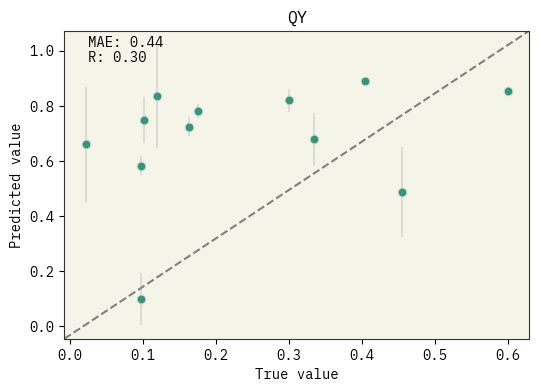

In [62]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

mae = lambda a, b: np.mean(np.abs(a - b))
rmse = lambda a, b: np.sqrt(np.mean((a - b)**2))

axs.set_title("QY")
sns.scatterplot(x=y_1, y=[yi.mean() for yi in yhat_1], ax=axs)
axs.set_xlabel("True value")
axs.set_ylabel("Predicted value")
axs.plot([0, 1], [0, 1], transform=axs.transAxes, ls="--", color="gray")
axs.errorbar(x=y_1, y=[yi.mean() for yi in yhat_1], yerr=[yi.std() for yi in yhat_1], fmt='o', color='gray', alpha=0.2)
axs.text(0.05, 0.95, f"MAE: {mae(np.array(y_1), np.array([yi.mean() for yi in yhat_1])):.2f}", transform=axs.transAxes)
axs.text(0.05, 0.90, f"R: {np.corrcoef(y_1, [yi.mean() for yi in yhat_1])[0, 1]:.2f}", transform=axs.transAxes)

plt.show()

## Predicting f=QY*AUC2

In [ ]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the scoring ranking the last experiment. Each answer should be numeric and ends with ###. Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4o",
    selector_k=5,
    temperature=0.7
)

## Testing prediction

In [96]:
df = pd.read_csv('Data/procedures_new.tsv', sep="\t")
prompts = df['prompt'].tolist()
labels_f = df['obj_f'].to_list()

In [97]:
import numpy as np
indexes = np.arange(len(prompts))
np.random.shuffle(indexes)
split = (len(indexes)-12)/len(indexes)

train_indexes = indexes[:int(split*len(indexes))]
test_indexes = indexes[int(split*len(indexes)):]

In [98]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7,
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
else:
    inv_system_message = ""

for i in train_indexes:
  if labels_f[i] >= 0:
    asktell.tell(prompts[i], labels_f[i])

In [ ]:
yhat=[]
y=[]
for i in test_indexes:
  yhat.append(asktell.predict(prompts[i] , system_message=""))
  y.append(labels_f[i]) 

In [ ]:
for i in test_indexes:
  print(f"{prompts[i]} => {labels_f[i]}")

# [f"{i.mean():.2f}" for i in yhat], y

In [ ]:
def rmse(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.mean((a - b)**2))

sum = 0
print(f"| {'predicted':^23s} | {'label':^10s} | {'AE':^10s} | ")
n = 0
for ihat, i in zip(yhat, y):
  n+=1
  mae = abs(ihat.mean()-i)
  print(f"| {ihat.mean():^10.2f}+/-{ihat.std():^10.2f} | {i:^10.2f} | {mae:^10.2f} |")
  sum += mae
print(f"\n{'RMSE: ':>20s}{rmse([ihat.mean() for ihat in yhat], y):<18.2f}")

import matplotlib.pyplot as plt
yhat_mean = [ihat.mean() for ihat in yhat]
y_plot    = np.array(y)[np.where(np.array(yhat_mean) <= 1)]
yhat_plot = np.array(yhat_mean)[np.where(np.array(yhat_mean) <= 1)]
yerr_plot = np.array([ihat.std() for ihat in yhat])[np.where(np.array(yhat_mean) <= 1)]
plt.figure(figsize=(6, 4))
plt.xlabel('Experimental outcome')
plt.ylabel('Predicted outcome')
plt.plot(y_plot, yhat_plot, 'o')
plt.errorbar(y_plot, yhat_plot, yerr=yerr_plot, fmt='none')
plt.title('LLM prediction: f = QY * AUC2')
plt.plot((0,0.4), (0,0.4), '--')
plt.text(0.75, 0.90, f"RMSE: {rmse(y_plot, yhat_plot):.2f}", fontsize=12, transform=plt.gca().transAxes)
plt.show()

## Bayesian optimization

In [10]:
proc_list = pd.read_csv('Data/procedures.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pool_{pool_type}.txt", sep=';')
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list['prompt'].to_list())


In [ ]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

In [ ]:
max(labels_f)

In [ ]:
selected = asktell.ask(pool, aq_fxn="expected_improvement", k=5, inv_filter=15, aug_random_filter=1, inv_system_message=inv_system_message, system_message=system_message)
i = 0
for prompt, p in zip(selected[0], asktell.predict(selected[0], system_message=system_message)):
    print(f"{prompt} => {p.mean():.4f} +/- {p.std():.4f}\n")
    # print(f"{i+1}: {prompt}")
    i+=1


In [ ]:
i=0
for prompt in selected[0]:
    print(f"{i+1}: {prompt}\n")
    i+=1

## New exp suggestion

In [12]:
proc_list = pd.read_csv('Data/procedures.tsv', sep='\t')
prompts, labels_f = proc_list['prompt'].tolist(), proc_list['obj_f'].tolist()

pool_type = "processed"
pool_list = pd.read_csv(f"Data/pool_{pool_type}.txt", sep=';')
# pool = cloudpickle.load(open(f'Data/pool_{pool_type}.pkl', 'rb'))
pool = bolift.Pool(pool_list['prompt'].to_list())


In [ ]:
asktell = bolift.AskTellFewShotTopk(
    prefix="Complete the distance between the fluorescence peaks in the spectra measured for the last experiment."\
          " Each answer should be numeric and ends with ###." \
          " Use the following information to complete the prompt: \n",
    x_formatter=lambda x: f"the experimental procedure: {x}",
    y_name="the product of the quantum yield with the area under the fluorescence peak at 650 nm",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-3.5-turbo",
    selector_k=5,
    temperature=0.7
)

system_message_path = "Data/system_message.txt"
inv_system_message_path = "Data/inv_system_message.txt"

if os.path.exists(system_message_path):
    with open(system_message_path, "r") as f:
        system_message = f.read()
    print("Loaded system message")
else:
    system_message = ""

if os.path.exists(inv_system_message_path):
    with open(inv_system_message_path, "r") as f:
        inv_system_message = f.read()
    print("Loaded inv system message")
else:
    inv_system_message = ""

print(pool)

for p,l in zip(prompts, labels_f):
  asktell.tell(p, float(l))
  try:
    pool.choose(p)
  except:
    continue

print(pool)

In [ ]:
max(labels_f)

In [22]:
propts = []
preds_mean = []
preds_std = []

for p in pool:
  propts.append(p)
  pred = asktell.predict(p, system_message=system_message)
  preds_mean.append(pred.mean())
  preds_std.append(pred.std())

predicted_pool = pd.DataFrame({
  'prompt': propts, 
  'pred_mean': preds_mean,
  'pred_std': preds_std
  })

In [ ]:
predicted_pool.sort_values(by='pred_mean', ascending=True, inplace=True)
predicted_pool.to_csv(f'Data/predicted_pool_{pool_type}.txt', sep=';', index=False)
predicted_pool

In [56]:
filtered_pool = predicted_pool[predicted_pool['pred_mean'] < 0.7]
filtered_pool = filtered_pool[filtered_pool['pred_std'] < 0.1]

In [ ]:
# plot filtered+pool means using pred_std as error
plt.figure(figsize=(6, 4))
plt.errorbar(range(len(filtered_pool)), filtered_pool['pred_mean'],yerr=filtered_pool['pred_std'], fmt='.', alpha=0.2, color='gray')
plt.scatter(range(len(filtered_pool)), filtered_pool['pred_mean'], label='Filtered pool')
plt.xlabel('Predicted outcome')
plt.ylabel('Experiment index')
plt.title('Predicted outcomes for the filtered pool')
plt.show()

In [ ]:
for l in [2,4,23, 950,953,947, 965,964,962]:
# for l in range(900, 950):
  print(f''' ------------ [index: {l}] ------------
  prompt: {filtered_pool.iloc[l]['prompt']}
  prediction: {filtered_pool.iloc[l]['pred_mean']} +/- {filtered_pool.iloc[l]['pred_std']}
  ''')